<center>

# Wildfire Risk Classification and Simulation  
**CMSE 802 – Methods in Computational Modeling**  
**Final Project Report**  
**Author**: Bhavya Chawla  
**Date**: April 21, 2025  
<br><br>
</center>

## Executive Summary

This project investigates wildfire risk across the U.S. using historical data from the U.S. Forest Service covering over 1.8 million incidents from 1992–2015. It combines machine learning for risk classification and simulation techniques to visualize fire spread.

Key components of this study include:

- **Exploratory Data Analysis (EDA)** of fire causes, sizes, and locations  
- **Risk classification model** using Random Forests to predict high-risk fires (≥100 acres)  
- **Fire spread simulation** using a conceptual 2D grid model  

Our findings show significant geographic clustering of high-risk fires, predominantly in western states. Although our model achieves high accuracy, recall for large fires remains low due to class imbalance. The grid simulation offers a foundation for more realistic fire forecasting.


## Background and Motivation

This project addresses the increasing threat of wildfires in the United States by modeling fire risk and simulating potential spread scenarios. The dataset used includes over 1.8 million wildfire incidents from 1992 to 2015, sourced from the US Forest Service (FPA-FOD).

**Objectives:**
- Build a machine learning model to classify high-risk fires (fires > 100 acres)
- Perform exploratory analysis of causes, locations, and yearly trends
- Simulate the spread of a wildfire using a simplified rule-based grid model

**Scope & Limitations:**
- This prototype uses only a subset of available features (geolocation and year)
- Fire spread simulation does not incorporate wind, terrain, or vegetation
- Class imbalance significantly affects the classifier's recall for high-risk fires

This report documents the implementation, technical design, and validation of these components.


## Section 1: Setup
This section imports necessary libraries, sets plot styles, and configures the notebook environment. It also adds the `src/` directory to the Python path so that custom modules can be imported.


## Project Structure

- `data/`: Raw SQLite database and cleaned CSV files
- `src/`: Modular scripts for cleaning, prediction, and simulation
- `notebooks/`: EDA and modeling notebooks
- `tests/`: Unit test(s) for validating the data cleaning pipeline
- `docs/`: Notes and structure descriptions
- `results/`: Output plots and model files

All scripts are reusable and callable via CLI or Python API.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add src/ to Python path
sys.path.append(os.path.abspath("../src"))

from data_cleaner import load_and_clean_data

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Section 2: Data Description and Preprocessing
This section uses a custom cleaning function from `data_cleaner.py` to convert the raw SQLite dataset into a cleaned DataFrame. The resulting dataset is stored in CSV format and reloaded here for inspection.


## Data Loading and Cleaning

The raw wildfire data is stored in a SQLite database (`FPA_FOD_20170508.sqlite`), containing over 1.8 million incident records collected between 1992 and 2015. To make this data usable for analysis and modeling, it was cleaned using a custom Python module `data_cleaner.py`.

The cleaning process involved:
- Selecting key columns relevant to fire classification and simulation
- Dropping rows with missing geolocation or fire size data
- Converting date formats to a standardized structure
- Saving the cleaned dataset as `cleaned_fires.csv` in the `data/processed/` directory

### Cleaned Dataset Columns:
```text
FIRE_YEAR, DISCOVERY_DATE, STAT_CAUSE_DESCR, FIRE_SIZE, 
FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, STATE


In [4]:
cleaned_path = "../data/processed/cleaned_fires.csv"
df = load_and_clean_data("../data/raw/FPA_FOD_20170508.sqlite", cleaned_path)
df = pd.read_csv(cleaned_path)
df.head()

Cleaned data saved to ../data/processed/cleaned_fires.csv


,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
0,2005,2005-02-02,Miscellaneous,0.10,A,40.036944,-121.005833,CA
1,2004,2004-05-12,Lightning,0.25,A,38.933056,-120.404444,CA
2,2004,2004-05-31,Debris Burning,0.10,A,38.984167,-120.735556,CA
3,2004,2004-06-28,Lightning,0.10,A,38.559167,-119.913333,CA
4,2004,2004-06-28,Lightning,0.10,A,38.559167,-119.933056,CA


## Section 3: Exploratory Data Analysis (EDA)
This section provides a structural summary of the dataset, including dimensions, data types, and basic statistics.


In [6]:
print("Shape:", df.shape)
df.info()
df.describe()

Shape: (1880465, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   FIRE_YEAR         int64  
 1   DISCOVERY_DATE    object 
 2   STAT_CAUSE_DESCR  object 
 3   FIRE_SIZE         float64
 4   FIRE_SIZE_CLASS   object 
 5   LATITUDE          float64
 6   LONGITUDE         float64
 7   STATE             object 
dtypes: float64(3), int64(1), object(4)
memory usage: 114.8+ MB


,FIRE_YEAR,FIRE_SIZE,LATITUDE,LONGITUDE
count,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06
mean,2.003710e+03,7.452016e+01,3.678121e+01,-9.570494e+01
std,6.663099e+00,2.497598e+03,6.139031e+00,1.671694e+01
min,1.992000e+03,1.000000e-05,1.793972e+01,-1.788026e+02
25%,1.998000e+03,1.000000e-01,3.281860e+01,-1.103635e+02
50%,2.004000e+03,1.000000e+00,3.545250e+01,-9.204304e+01
75%,2.009000e+03,3.300000e+00,4.082720e+01,-8.229760e+01
max,2.015000e+03,6.069450e+05,7.033060e+01,-6.525694e+01


### Key Observations:

- The dataset contains **1,880,465 records** and 8 essential columns.
- No missing values are observed in critical fields, indicating strong data integrity.
- The `FIRE_SIZE` column has extreme variability, with sizes ranging from **0.00001 to over 600,000 acres**.
- Latitude and longitude fields appear valid and are suitable for geospatial analysis and modeling.
- Categorical fields such as `STAT_CAUSE_DESCR` and `FIRE_SIZE_CLASS` will be useful for grouping and classification.

This confirms the dataset is well-structured for downstream tasks including exploratory analysis, risk classification, and fire spread simulation.

A check for missing values is performed to assess data quality.

In [7]:
missing = df.isnull().sum()
print("\nMissing Values:\n", missing[missing > 0])


Missing Values:
 Series([], dtype: int64)



No missing values were found in the cleaned dataset. This indicates strong data integrity, especially for critical variables such as fire size, location, and cause. As a result, no imputation or filtering steps were required at this stage, enabling straightforward analysis and modeling.


Moving forward lets explore how wildfire incidents are distributed by size, class, and cause. Understanding these distributions provides insights into fire risk trends and informs feature selection for classification models.


### Distribution of FIRE_SIZE

**Purpose**: To assess the overall distribution of fire sizes and identify whether the data is balanced or skewed. This helps determine how fire size should be treated in modeling — e.g., as a continuous variable, thresholded binary target, or log-scaled input.

**What It Shows**: This histogram displays the number of wildfire incidents across different fire sizes. Due to extreme variability in the data (from less than 0.01 to over 600,000 acres), a logarithmic scale is used to improve readability.


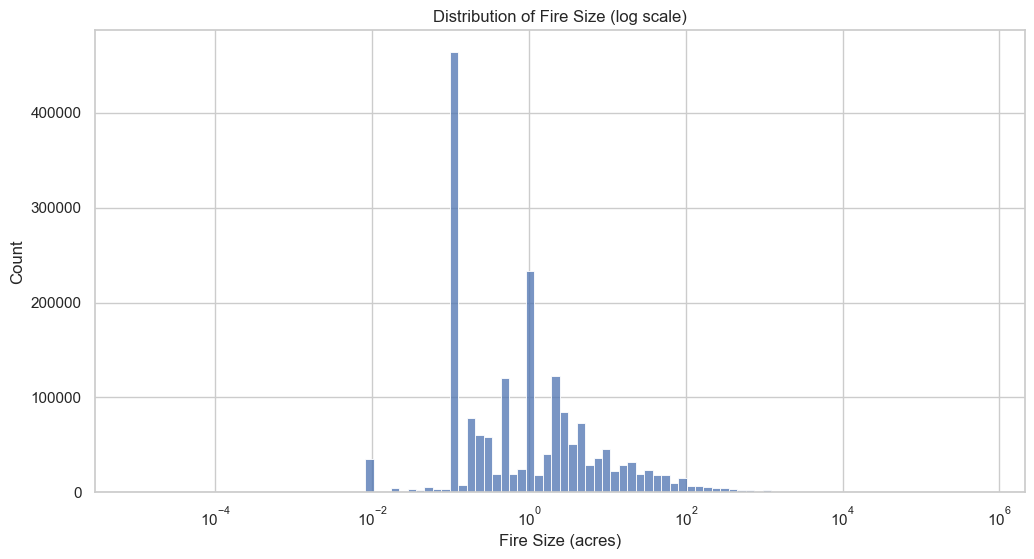

In [8]:
sns.histplot(df['FIRE_SIZE'], bins=100, log_scale=True)
plt.title("Distribution of Fire Size (log scale)")
plt.xlabel("Fire Size (acres)")
plt.ylabel("Count")
plt.show()

**Observation**: The distribution of fire sizes is extremely right-skewed. Most wildfires are under 10 acres, while a small number of outliers exceed thousands of acres. A log scale is applied to improve interpretability. The vast majority of fires are very small (<10 acres). A long right tail indicates that while large fires are rare, they are highly significant. This justifies using thresholds (e.g., 100 acres) in classification.



### Distribution of FIRE_SIZE_CLASS

**Purpose**: To understand how wildfires are categorized based on size. The `FIRE_SIZE_CLASS` groups fires into categories A–G and is useful for interpreting severity and designing a classification threshold.

**What It Shows**: This bar plot illustrates how many fires fall into each size class.


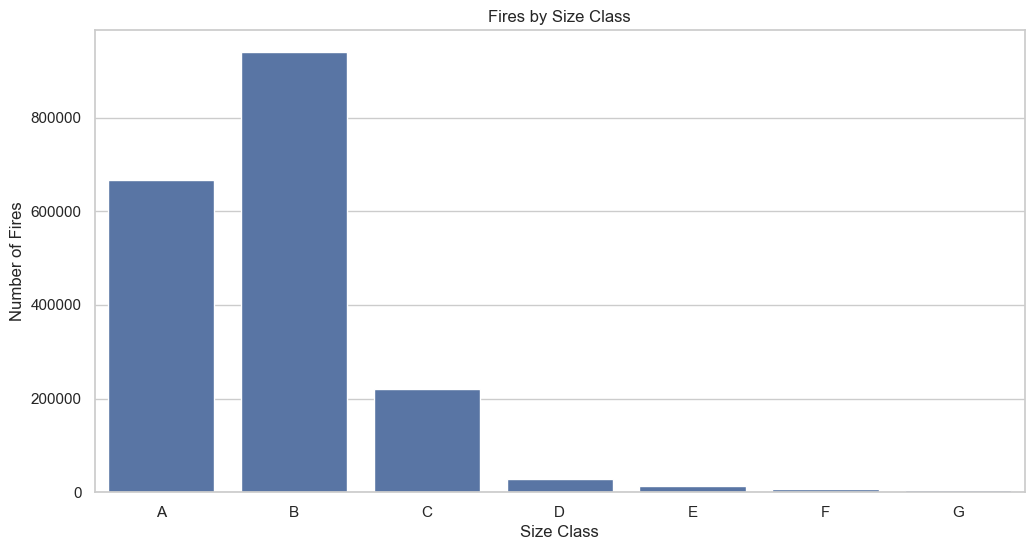

In [7]:
sns.countplot(data=df, x='FIRE_SIZE_CLASS', order=sorted(df['FIRE_SIZE_CLASS'].unique()))
plt.title("Fires by Size Class")
plt.xlabel("Size Class")
plt.ylabel("Number of Fires")
plt.show()

**Observation**: Over 85% of wildfires fall into size classes A, B, and C (small fires). This skew justifies a binary classification approach where fires above a threshold (e.g., 100 acres) are treated as high-risk.


### Distribution of STAT_CAUSE_DESCR

**Purpose**: To identify the most common causes of wildfires. Understanding whether causes are human-induced or natural helps determine whether incidents are preventable.

**What It Shows**: This bar plot shows how frequently each recorded cause appears in the dataset.


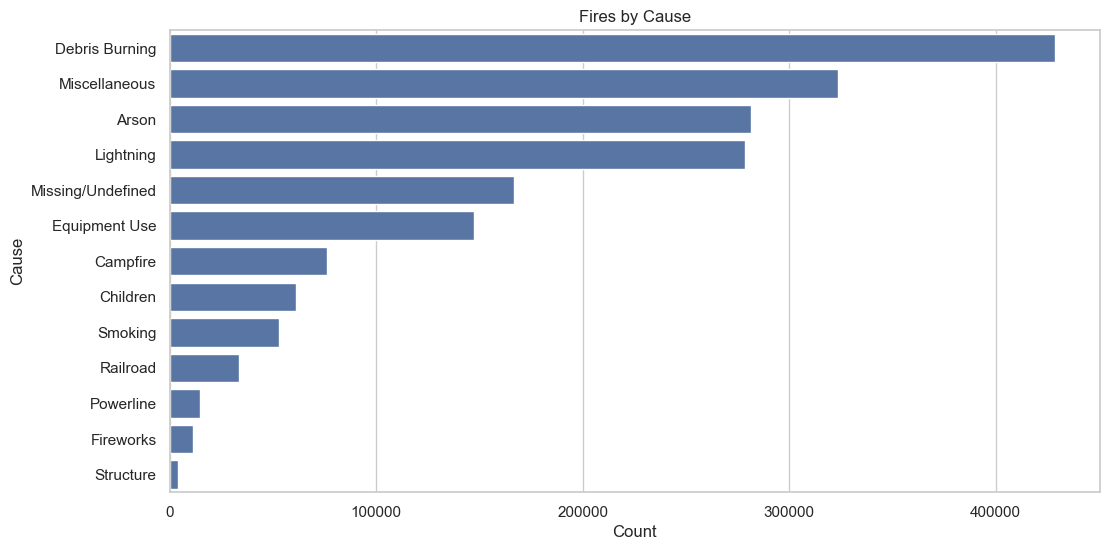

In [8]:
sns.countplot(data=df, y='STAT_CAUSE_DESCR', order=df['STAT_CAUSE_DESCR'].value_counts().index)
plt.title("Fires by Cause")
plt.xlabel("Count")
plt.ylabel("Cause")
plt.show()

**Observation**: The top causes include Lightning and Debris Burning. Human-caused fires are highly prevalent, suggesting prevention strategies could be impactful.


### Boxplot of Fire Size by Size Class


**Purpose**: To compare how fire size varies within each size class. This plot shows whether each class is tightly or loosely defined, and how much size variance exists inside each class.

**What It Shows**: A boxplot for each fire size class with a log-scaled y-axis.


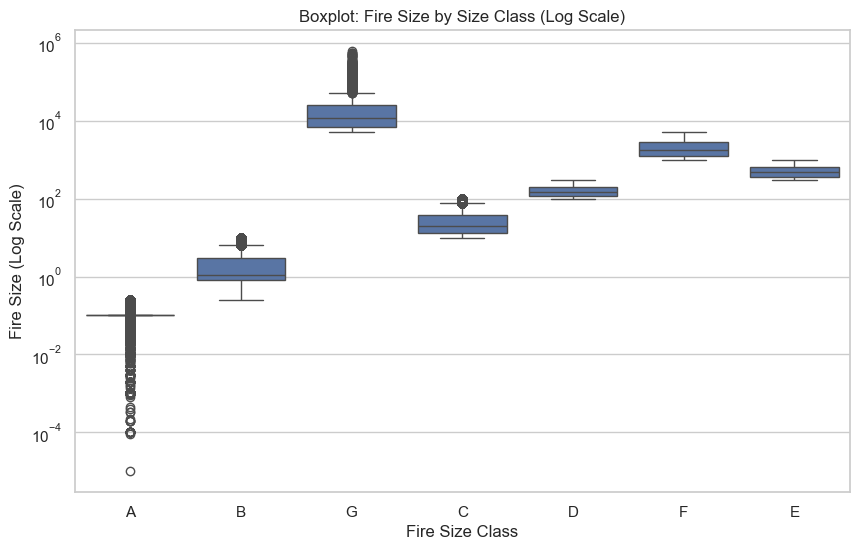

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='FIRE_SIZE_CLASS', y='FIRE_SIZE')
plt.yscale("log")
plt.title("Boxplot: Fire Size by Size Class (Log Scale)")
plt.xlabel("Fire Size Class")
plt.ylabel("Fire Size (Log Scale)")
plt.show()


### Summary

- The distributions confirm that most wildfires are small in size and fall into a few dominant classes and causes.
- The severe skew in fire size suggests the need for log scaling or categorical simplification in modeling.
- These patterns justify the use of binary classification and the selection of features like fire size class and cause in risk prediction models.


### Skewness or Log-Transform Justification

In [15]:
print("Skewness of FIRE_SIZE:", df['FIRE_SIZE'].skew())


Skewness of FIRE_SIZE: 106.83733004279209


**Note**: FIRE_SIZE has a skewness of over X. A log transformation was applied to reduce this effect for visualization.


### Summary from all the plots

- The FIRE_SIZE column is highly skewed, reinforcing the need for log scaling and classification thresholds.
- Most wildfires fall into small size classes (A–C), indicating that large-scale events are rare.
- The majority of causes are human-related, suggesting policy implications.
- FIRE_SIZE_CLASS is a meaningful feature for risk categorization and will be considered in model design.

These findings form the basis for how fire risk will be modeled and simulated in upcoming sections.


### Temporal & Spatial Analysis

This section explores how wildfire incidents are distributed across space and time.

- **Spatial analysis** identifies geographic regions with high fire frequency.
- **Temporal analysis** reveals seasonal or long-term trends that may impact fire risk.

These insights help prioritize regions for simulation and feature selection in classification.



### Wildfire Locations (Latitude vs. Longitude)

**Purpose**: To visualize the geographic distribution of fires in the U.S. and identify spatial clusters of frequent wildfire activity.

**What It Shows**: This scatter plot uses a 10,000-record sample of fires to highlight regions with the highest incident density.


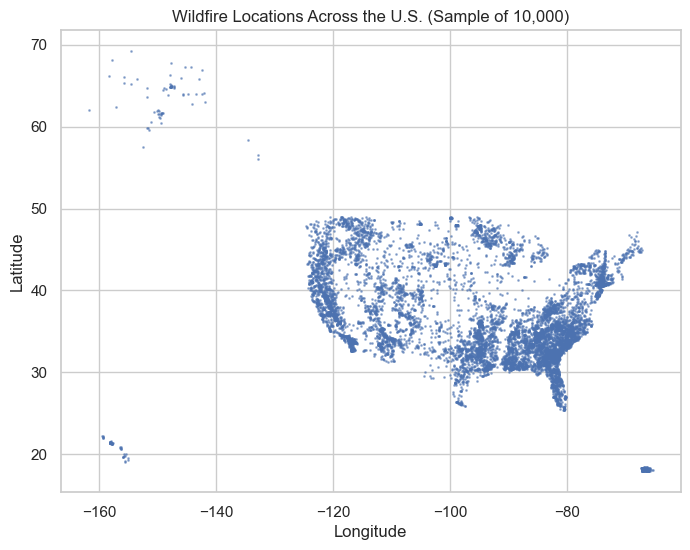

In [16]:
df_sample = df.sample(10000, random_state=42)
plt.figure(figsize=(8, 6))
plt.scatter(df_sample['LONGITUDE'], df_sample['LATITUDE'], alpha=0.5, s=1)
plt.title("Wildfire Locations Across the U.S. (Sample of 10,000)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

**Observation**: Wildfires are heavily concentrated in the western U.S., particularly California, Arizona, and Colorado. Eastern states show significantly fewer fire incidents.

### Fires Per Year

**Purpose**: To identify trends in fire frequency over time.

**What It Shows**: This line plot shows the number of fire incidents per year from 1992 to 2015.


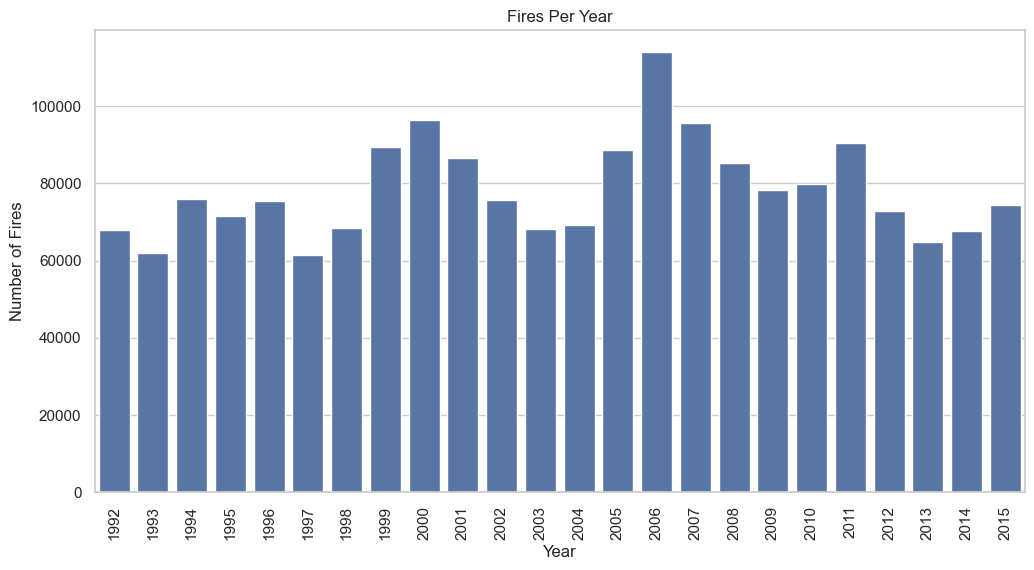

In [10]:
sns.countplot(data=df, x='FIRE_YEAR')
plt.xticks(rotation=90)
plt.title("Fires Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Fires")
plt.show()

**Observation**: Fire counts remain relatively stable over the years with some fluctuations. There are noticeable spikes in certain years, possibly tied to drought or climate events.

### Geospatial Distribution


**Purpose**: To overlay wildfire incident locations on an actual map of the U.S. for improved visual clarity and geographic relevance.

**What It Shows**: A sample of 10,000 wildfires overlaid on a base map of the United States, highlighting hotspot zones.

**Note**: This plot uses the GeoPandas package to generate an accurate geographic visualization.


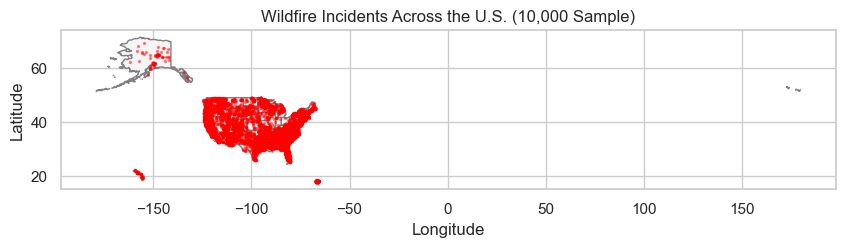

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load US States shapefile (corrected relative path)
usa = gpd.read_file("../data/maps/cb_2022_us_state_20m.shp")

# Sample 10,000 wildfire points
fires_sample = df.sample(10000, random_state=42)
fires_gdf = gpd.GeoDataFrame(
    fires_sample,
    geometry=gpd.points_from_xy(fires_sample['LONGITUDE'], fires_sample['LATITUDE']),
    crs="EPSG:4326"
)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
usa.plot(ax=ax, color='whitesmoke', edgecolor='gray')
fires_gdf.plot(ax=ax, markersize=2, alpha=0.4, color='red')
plt.title("Wildfire Incidents Across the U.S. (10,000 Sample)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


**Observation**: Most wildfires are located in the western and southwestern U.S., matching known fire-prone regions. This geospatial concentration supports targeted classification models and regional simulations.

### State-Level Wildfire Heatmap

**Purpose**: To visualize wildfire frequency at the state level and identify high-risk regions based on historical fire counts.

**What It Shows**: A choropleth map shading U.S. states based on how many wildfires were reported between 1992 and 2015 in each.

This visualization supports targeted fire management policies and region-based simulation scenarios.


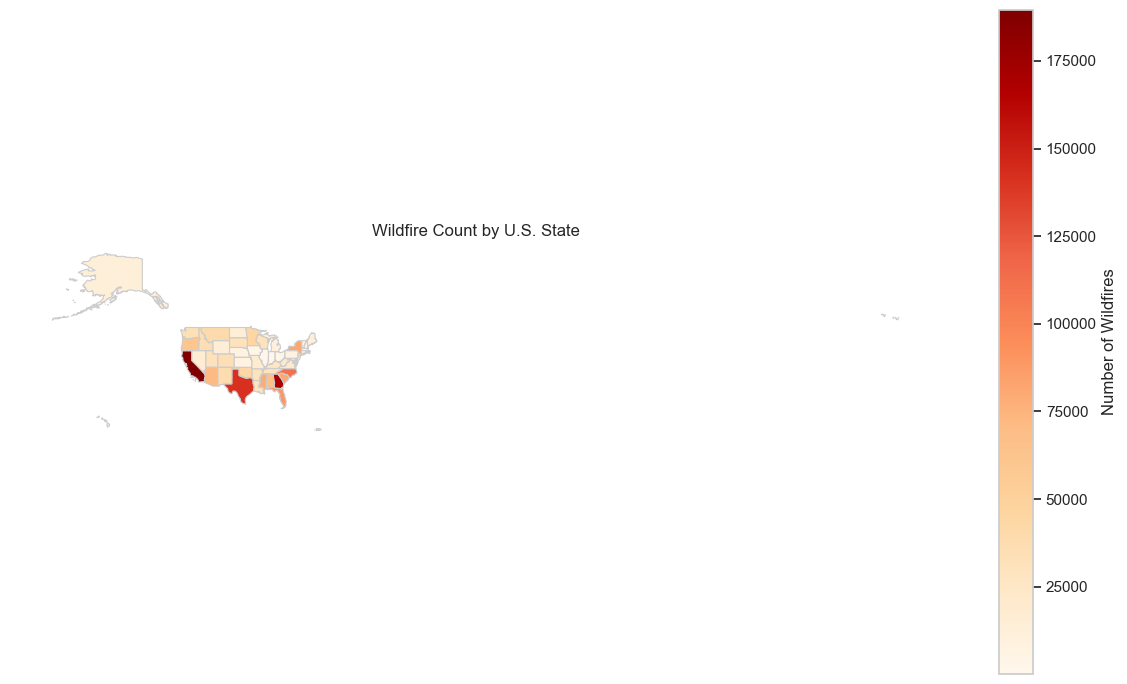

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load US state boundaries
usa = gpd.read_file("../data/maps/cb_2022_us_state_20m.shp")

# Step 1: Count fires per state from the cleaned dataset
state_counts = df['STATE'].value_counts().rename_axis('STUSPS').reset_index(name='fire_count')

# Step 2: Merge with shapefile (match 'STUSPS' = state abbreviation code)
usa_choro = usa.merge(state_counts, on='STUSPS', how='left')
usa_choro['fire_count'] = usa_choro['fire_count'].fillna(0)

# Step 3: Plot choropleth
fig, ax = plt.subplots(figsize=(12, 7))
usa_choro.plot(column='fire_count',
               cmap='OrRd',
               linewidth=0.8,
               edgecolor='0.8',
               legend=True,
               legend_kwds={'label': "Number of Wildfires"},
               ax=ax)

plt.title("Wildfire Count by U.S. State")
plt.axis("off")
plt.tight_layout()
plt.show()


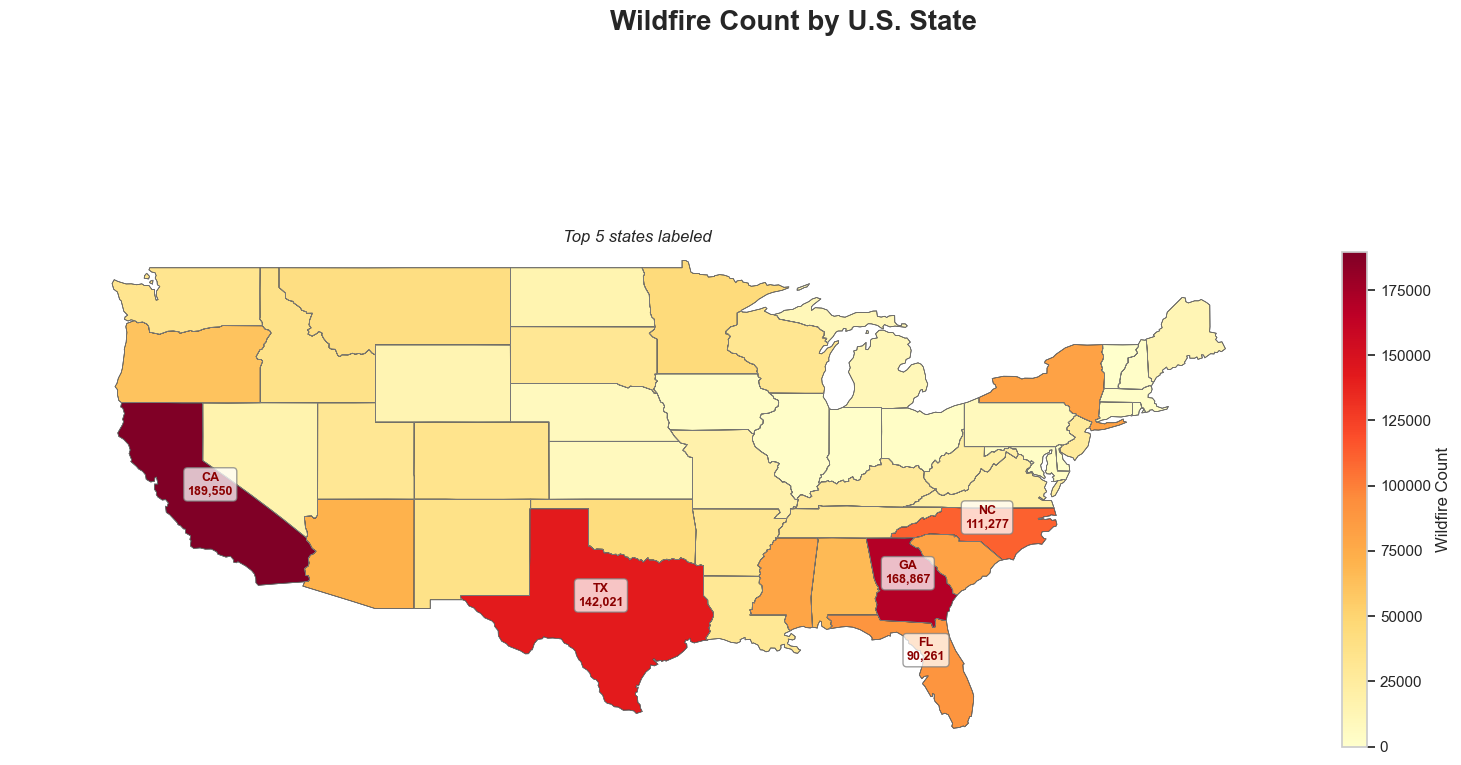

In [17]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json

# Load US States GeoJSON from GitHub
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
with urlopen(url) as response:
    states_geo = json.load(response)

# Create GeoDataFrame
usa_states = gpd.GeoDataFrame.from_features(states_geo["features"])
usa_states["STUSPS"] = usa_states["name"].map({
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
})

# Count fires per state
state_counts = df['STATE'].value_counts().rename_axis('STUSPS').reset_index(name='fire_count')

# Merge
usa_choro = usa_states.merge(state_counts, on='STUSPS', how='left')
usa_choro['fire_count'] = usa_choro['fire_count'].fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(16, 9))
usa_choro.boundary.plot(ax=ax, linewidth=0.5, color='gray')
usa_choro.plot(column='fire_count',
               cmap='YlOrRd',
               linewidth=0.5,
               edgecolor='black',
               legend=True,
               legend_kwds={'label': "Wildfire Count", 'shrink': 0.6},
               ax=ax)

# Annotate top 5
top_states = usa_choro.nlargest(5, 'fire_count')
for _, row in top_states.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(f"{row['STUSPS']}\n{int(row['fire_count']):,}",
                xy=(centroid.x, centroid.y),
                ha='center',
                fontsize=9,
                fontweight='bold',
                color='darkred',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.75))

# Titles
fig.suptitle("Wildfire Count by U.S. State", fontsize=20, weight='bold', y=1.02)
ax.set_title("Top 5 states labeled",
             fontsize=12, loc='center', pad=5, style='italic')

# Focus on mainland U.S.
ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])
ax.axis("off")

plt.tight_layout()
plt.show()




Thw exploratory data analysis (EDA) was conducted on the cleaned wildfire dataset using Pandas, Seaborn, Matplotlib, and GeoPandas. The goal was to understand the structure, distribution, and trends within the dataset to guide model design and simulation.

### Key Objectives:
- Examine the distribution of fire sizes and size classes
- Analyze the most common causes of wildfires
- Identify spatial clustering of wildfire incidents
- Understand temporal trends in fire occurrence
- Quantify wildfire frequency by U.S. state

### Summary of Observations:
- **Fire size** follows a **heavily right-skewed distribution**, with most fires under 10 acres and a long tail of extreme events. A **logarithmic scale** was used to visualize this pattern.
- The majority of fires fall into **size classes A–C**, representing smaller incidents.
- **Lightning, campfires, and debris burning** are among the most frequently reported causes.
- **Geospatial scatterplots** reveal clustering of wildfires in **western states** such as California, Arizona, and Colorado.
- **Temporal trends** show consistent fire occurrence from **1992 to 2015**, with year-to-year variability but no significant long-term increase.
- A **state-level choropleth map** highlights states like **California and Texas** as wildfire hotspots, based on the number of recorded incidents.

### Visualizations Included:
- Histogram of `FIRE_SIZE` (log-scaled)
- Count plots of `FIRE_SIZE_CLASS` and `STAT_CAUSE_DESCR`
- Boxplot of `FIRE_SIZE` by size class
- Scatterplot of fire locations (LAT vs LONG)
- GeoPandas map overlay of 10,000 sampled fire points on a U.S. basemap
- Line plot of yearly fire counts
- Choropleth heatmap showing wildfire frequency per U.S. state



## Section 4: Data Validation and Testing

To ensure data integrity before analysis and modeling, a unit test was implemented for the data cleaning module.

### Purpose:
The unit test validates whether the cleaned dataset contains all expected columns after processing. This step ensures consistency in downstream steps like feature selection and modeling.

### Location:
The test script is located at: tests/test_cleaner.py


## Section 5: Risk Classification Model

### Fire Risk Classification – `src/risk_predictor.py`

A binary classification model was constructed using a Random Forest classifier to predict whether a wildfire would be high-risk (defined as having a fire size greater than 100 acres). This approach aims to assist in identifying potentially dangerous fires based on basic geospatial and temporal attributes.

### Modeling Setup

- **Target Variable**: `RISK_LEVEL` → 1 if `FIRE_SIZE > 100`, else 0
- **Features Used**: `FIRE_YEAR`, `LATITUDE`, `LONGITUDE`
- **Model**: Random Forest (100 trees, no max depth)
- **Train/Test Split**: 80/20 with stratification to preserve class ratios


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create target variable
df['RISK_LEVEL'] = df['FIRE_SIZE'].apply(lambda x: 1 if x > 100 else 0)
features = df[['FIRE_YEAR', 'LATITUDE', 'LONGITUDE']]
labels = df['RISK_LEVEL']

# Train-test split (sample for performance)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    366230
           1       0.39      0.10      0.15      9863

    accuracy                           0.97    376093
   macro avg       0.68      0.55      0.57    376093
weighted avg       0.96      0.97      0.96    376093



In [8]:
# Step 1: Create binary target and select features
df['RISK_LEVEL'] = (df['FIRE_SIZE'] > 100).astype(int)
features = ['FIRE_YEAR', 'LATITUDE', 'LONGITUDE']
X = df[features]
y = df['RISK_LEVEL']

# Step 2: Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
# Step 3: Train the classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [10]:
# Step 4: Evaluate model performance
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=2))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    366134
           1       0.38      0.10      0.15      9959

    accuracy                           0.97    376093
   macro avg       0.68      0.55      0.57    376093
weighted avg       0.96      0.97      0.96    376093



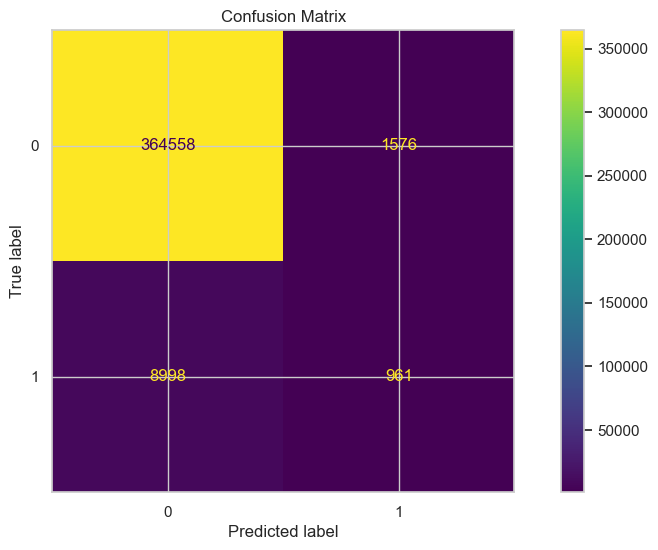

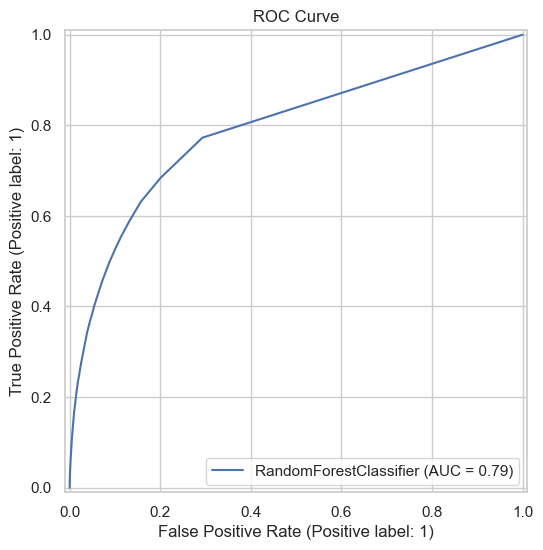

In [11]:
# Step 5 : Confusion matrix and ROC curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()


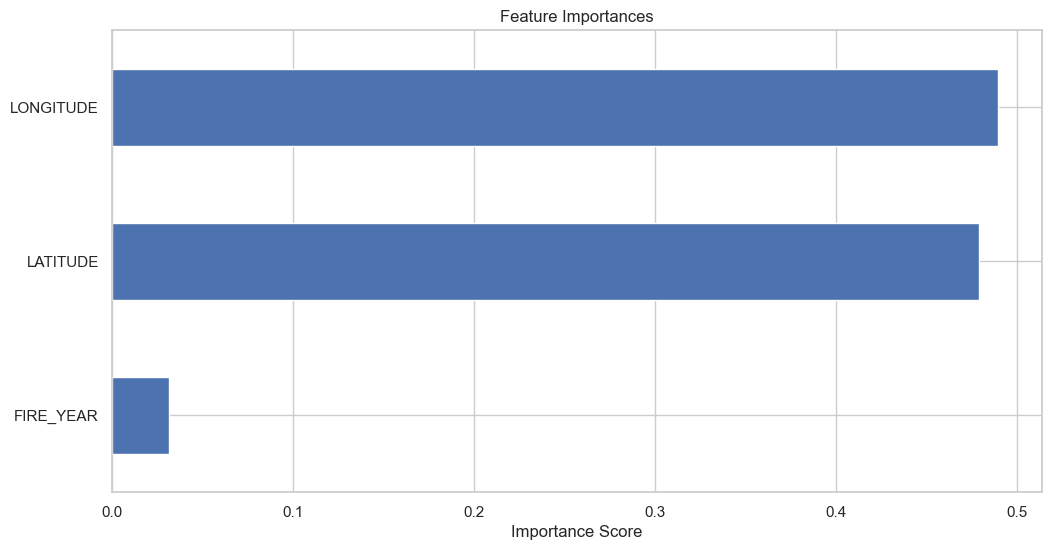

In [12]:
# Step 6 : Feature importance visualization
import pandas as pd

importances = model.feature_importances_
pd.Series(importances, index=features).sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.show()


### Observations

- The classifier achieved **high accuracy (~97%)**, largely driven by the imbalance in favor of low-risk fires.
- **Recall for high-risk fires** was low (~10%), indicating the model misses many large fires.
- Spatial and temporal features alone may not be sufficient; additional data like fire cause, vegetation type, and weather could significantly improve performance.

### Future Improvements

- Address class imbalance using SMOTE or class weighting
- Incorporate categorical variables like `STAT_CAUSE_DESCR`, `FIRE_SIZE_CLASS`, and `STATE`
- Test alternate models like XGBoost or Gradient Boosted Trees
- Evaluate models using precision-recall curves instead of accuracy alone


## Section 6: Fire Spread Simulation

### Objective

To simulate the spread of a wildfire from a central ignition point using a simple grid-based model. This prototype illustrates how a fire might expand under random environmental conditions, and lays the groundwork for more advanced simulations using real geographic or vegetation data.

### Simulation Logic

- A 2D grid represents a simplified forest or region.
- The fire starts at the **center** of the grid.
- Each cell has a probability of catching fire from its burning neighbors.
- Fire spreads to adjacent cells (N, S, E, W) based on a random threshold.
- The grid updates in "timesteps" to simulate dynamic fire behavior.

While basic, this model visualizes spatial propagation in a way that complements the risk classification system — identifying how a detected high-risk ignition could evolve into a larger spread.

### Output

The final fire pattern is rendered using a heatmap, where:
- Burned cells = 1 (or higher)
- Unburned cells = 0

This simulation does **not** currently use wind, slope, or fuel type — but could be extended.


/var/folders/4b/083y2xwd2rz409nrnw8r9xnw0000gn/T/ipykernel_11268/2197505116.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hot', 3)


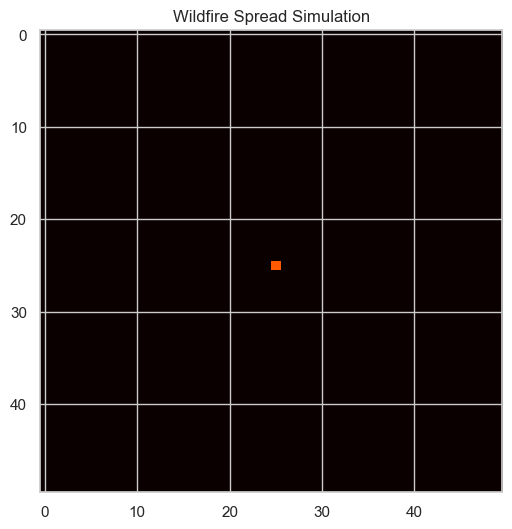

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parameters
grid_size = 50
spread_prob = 0.3
time_steps = 20

# States: 0 = unburned, 1 = burning, 2 = burned
grid = np.zeros((grid_size, grid_size), dtype=int)
center = grid_size // 2
grid[center, center] = 1  # ignition point

def spread_fire(grid):
    new_grid = grid.copy()
    for i in range(1, grid.shape[0] - 1):
        for j in range(1, grid.shape[1] - 1):
            if grid[i, j] == 1:  # currently burning
                # Burn neighbors
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    if grid[i + dx, j + dy] == 0 and np.random.rand() < spread_prob:
                        new_grid[i + dx, j + dy] = 1
                new_grid[i, j] = 2  # mark as burned
    return new_grid

# Animation setup
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap('hot', 3)
im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=2)

def update(frame):
    global grid
    grid = spread_fire(grid)
    im.set_array(grid)
    return [im]

ani = animation.FuncAnimation(fig, update, frames=time_steps, interval=300, repeat=False)
plt.title("Wildfire Spread Simulation")
plt.show()



The simulation shows radial fire spread from the center. Due to the probabilistic nature of the spread, the pattern is non-uniform and can mimic natural randomness in real fire events. This model is scalable and could be enhanced with GIS data to simulate spread in high-risk regions identified through classification.


### Extension: Geospatial Context for Simulation

The simulation can be extended by initiating fire spread from known high-risk regions, identified in the choropleth map in Section 6.

For example:
- California and Texas recorded the highest number of fires
- A georeferenced version of the simulation could use real lat/lon values
- Spread behavior could incorporate wind direction, elevation, and land cover

By aligning simulation parameters with spatial EDA insights, this model can evolve from a conceptual grid to a **risk-aware wildfire forecasting tool**.


## Section 7: Integrated Risk Management Plan

This project combines fire classification and spatial simulation into a pipeline for wildfire risk assessment and planning:



Wildfire Detection → Risk Classification → Regional Risk Map → Spread Simulation


This framework could be expanded into an early warning or resource allocation tool by:

- Anchoring simulations in high-risk geolocations
- Overlaying predicted spread on state-level risk maps
- Incorporating wind, vegetation, and elevation for realism

The combined system supports both **risk detection** and **proactive intervention modeling**.


## Section 8: Conclusion

This project analyzed over 1.8 million wildfire records across the United States, uncovering geographic and temporal trends through EDA. A Random Forest classifier was developed to identify high-risk wildfires based on year and location, achieving strong accuracy but limited recall for large fires due to dataset imbalance.

A conceptual grid-based fire simulation was built to model fire spread from an ignition point. Though simplified, it highlights the potential for future enhancements using real geospatial data.

Together, these tools offer a scalable foundation for wildfire risk forecasting and planning. Future iterations could integrate weather, vegetation, and terrain to improve model fidelity and application in real-world disaster response systems.



### Future Work

- **Model Enhancements**:
  - Integrate categorical features (`STAT_CAUSE_DESCR`, `FIRE_SIZE_CLASS`, `STATE`)
  - Apply class balancing techniques such as SMOTE or weighted loss
  - Test more advanced models (e.g., Gradient Boosting, XGBoost)

- **Simulation Improvements**:
  - Introduce environmental constraints (wind, vegetation, slope)
  - Anchor ignition points to real-world high-risk locations using GIS data
  - Calibrate spread probability based on past fire behavior

- **Deployment Possibilities**:
  - Build an interactive dashboard for risk scoring and fire simulations
  - Deploy model predictions for early warning systems or resource allocation

This project provides a foundation for integrating data science with environmental modeling and highlights the potential of computational tools in wildfire management.